In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn

import datasets, transforms, GusarevModel, pytorch_msssim

# Paths
PATH_SAVE_NETWORK_INTERMEDIATE = "./runs/6LayerCNN/v5/network_intermediate.tar"
directory_source = "D:/data/JSRT/augmented/test/source/"
directory_boneless = "D:/data/JSRT/augmented/test/target/"

# Data
_batch_size = 10
image_spatial_size = (440,440)
discriminator_keys_images = ["source","boneless"]
ds = datasets.JSRT_CXR(directory_source, directory_boneless, 
                       transform=tvtransforms.Compose([
                             transforms.RescalingNormalisation(discriminator_keys_images,(0,1)),
                             transforms.RandomIntensityComplement(discriminator_keys_images, probability=0.5),
                             transforms.Rescale(image_spatial_size, discriminator_keys_images, None),
                             transforms.ToTensor(discriminator_keys_images),
                             ]))
print(len(ds))
dl = DataLoader(ds, _batch_size, shuffle=True, num_workers=0)
sample = next(iter(dl))
print(sample["source"].shape)

80
torch.Size([10, 1, 440, 440])


In [2]:
# Network
input_array_size = (_batch_size, 1, image_spatial_size[0], image_spatial_size[1])
net = GusarevModel.MultilayerCNN(input_array_size)
#net = nn.DataParallel(net, list(range(ngpu)))
if os.path.isfile(PATH_SAVE_NETWORK_INTERMEDIATE):
    print("=> loading checkpoint '{}'".format(PATH_SAVE_NETWORK_INTERMEDIATE))
    checkpoint = torch.load(PATH_SAVE_NETWORK_INTERMEDIATE, map_location='cpu')
    start_epoch = checkpoint['epoch_next']
    reals_shown_now = checkpoint['reals_shown']
    net.load_state_dict(checkpoint['model_state_dict'])
    print("=> loaded checkpoint '{}' (epoch {}, reals shown {})".format(PATH_SAVE_NETWORK_INTERMEDIATE, 
                                                                        start_epoch, reals_shown_now))
else:
    print("=> NO CHECKPOINT FOUND AT '{}'" .format(PATH_SAVE_NETWORK_INTERMEDIATE))
    raise RuntimeError("No checkpoint found at specified path.")

net.eval()
out = net(sample["source"])
out = out.detach()

Using 6-Layer MultiCNN Model.
=> loading checkpoint './runs/6LayerCNN/v5/network_intermediate.tar'
=> loaded checkpoint './runs/6LayerCNN/v5/network_intermediate.tar' (epoch 61, reals shown 243390)


(-0.5, 439.5, 439.5, -0.5)

<Figure size 432x288 with 0 Axes>

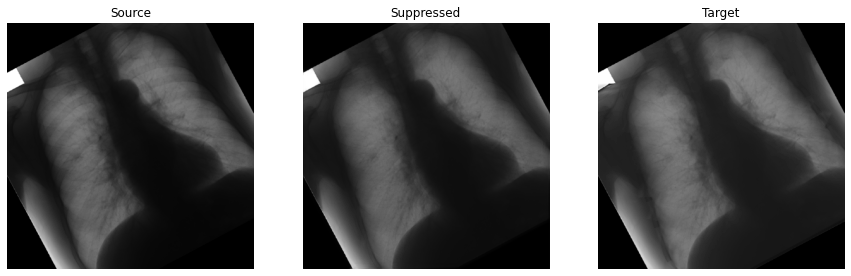

In [3]:
# Display
batch_idx = 8
plt.figure(1)
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(sample["source"][batch_idx,0,:],cmap='gray')
ax[0].set_title("Source")
ax[0].axis("off")
ax[1].imshow(out[batch_idx,0,:],cmap='gray')
ax[1].set_title("Suppressed")
ax[1].axis("off")
ax[2].imshow(sample["boneless"][batch_idx,0,:],cmap='gray')
ax[2].set_title("Target")
ax[2].axis("off")

In [4]:
# Analysis
def PSNR(image, reference, max_reference=1.):
    """ 
    Peak Signal-to-Noise Ratio
    Input image and reference assumed to be Torch Tensors of shape [NxCxHxW]
    """
    # Assume the image 
    H = image.size(-2)
    W = image.size(-1)
    MSE = (1/(H*W))*torch.sum((torch.abs(image - reference))**2, (-1,-2))
    rtMSE = torch.sqrt(MSE)
    
    output = 20*torch.log10(max_reference/rtMSE)
    return output.numpy().squeeze()

def NPS():
    """Noise Power Spectrum"""
    

def SSIM(image, reference):
    iters = 0
    out_list = np.ndarray(image.size(0))
    for im in image:
        im = im.numpy()
        im = np.moveaxis(im, 0,-1)
        ref = reference[iters,:].numpy()
        ref = np.moveaxis(ref, 0,-1)
        out = skimage.metrics.structural_similarity(im, ref, multichannel=True)
        out_list[iters]=out
        iters+=1
    return out_list

print("PSNR original: {} ; after denoising: {} ".format(PSNR(sample["source"], sample["boneless"]).mean(), PSNR(out, sample["boneless"]).mean()))
print("SSIM original: {} ; after denoising: {} ".format(SSIM(sample["source"], sample["boneless"]).mean(), SSIM(out, sample["boneless"]).mean()))


PSNR original: 32.612998962402344 ; after denoising: 34.40888214111328 
SSIM original: 0.9700765706235284 ; after denoising: 0.9855025204136393 
